<a href="https://colab.research.google.com/github/namtoptall/DataScience/blob/main/MLP306x_01-A_VN_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-b3eb1710-1f6d-7540-951b-5e8061032415)


In [2]:
!pip install mtcnn
!pip install opencv-python-headless
!pip install scikit-image
!pip install imutils
!pip install tensorflow
!pip install --upgrade kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=d98e964b389408f6b3b9322615737d0cc5f070d3af2ce533c082fb94189a2241
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.14
    Uninstalling kaggle-1.6.14:
      Successfully uninstalled kaggle-1.6.14


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 2. Khởi tạo tập dữ liệu

Lần này, dữ liệu sẽ không được cung cấp sẵn, bạn sẽ phải tự tạo ra một tập dữ liệu từ nhiều nguồn có sẵn và ghép chúng lại thành một tập dữ liệu duy nhất cho dự án này.

1. Đầu tiên, bạn phải download các tập dữ liệu từ các nguồn sau đây

    - https://www.kaggle.com/andrewmvd/face-mask-detection
	- https://www.kaggle.com/omkargurav/face-mask-dataset
	- https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
	- https://www.kaggle.com/vijaykumar1799/face-mask-detection
	- https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
	- https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
	- https://www.kaggle.com/sumansid/facemask-dataset
	- https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view
    
Bạn có thể thấy, các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. Chúng có thể được chứa trong các thư mục lớn hơn nữa là train, validation và test; nhưng điều này không đáng kể, bạn chỉ cần lưu ý 2 thư mục đã nêu ở trên.

2. Bạn đem các ảnh tải được bỏ vào trong thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

**Lưu ý:** Có thể sẽ có một vài tấm ảnh bị trùng giữa các nguồn dữ liệu khác nhau, bạn chỉ cần bỏ qua quá trình sao chép các tấm ảnh bị trùng này vào tập **dataset** là được.

## Đầu tiên, kết nối với google drive và kaggle
- cần có tài khoản kaggle và download kaggle api file

In [4]:
from google.colab import files
files.upload()  # Thực hiện tải tệp kaggle.json lên từ máy tính của bạn (phải có tài khoản kaggle nha)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namdz242221","key":"de869a9575f6ac51974bca65557d88a7"}'}

In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# mount drive content
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## download các tệp dữ liệu và giải nén

In [7]:
# Download datasets from Kaggle
!kaggle datasets download -d andrewmvd/face-mask-detection
!kaggle datasets download -d omkargurav/face-mask-dataset
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset
!kaggle datasets download -d vijaykumar1799/face-mask-detection
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!kaggle datasets download -d spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
!kaggle datasets download -d sumansid/facemask-dataset

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
100% 396M/398M [00:24<00:00, 13.9MB/s]
100% 398M/398M [00:24<00:00, 17.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
100% 163M/163M [00:08<00:00, 25.3MB/s]
100% 163M/163M [00:08<00:00, 20.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset
License(s): copyright-authors
100% 207M/207M [00:13<00:00, 22.6MB/s]
100% 207M/207M [00:13<00:00, 15.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection
License(s): CC0-1.0
... resuming from 416968083 bytes (-184151667 bytes left) ...
416 - Requested range not satisfiable
Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0
100% 330M/330M [00:19<00:00, 22.1MB/s]
100% 330M/330M [00:19<00:00, 18.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/spandanpatnaik09/fac

In [8]:
import os
import zipfile

# List of downloaded zip files
zip_files = [
    'face-mask-detection.zip',
    'face-mask-dataset.zip',
    'covid-face-mask-detection-dataset.zip',
    'face-mask-detection.zip',
    'face-mask-12k-images-dataset.zip',
    'face-mask-detectormask-not-mask-incorrect-mask.zip',
    'facemask-dataset.zip'
]

# Create a directory for the dataset if it doesn't exist
if not os.path.exists('dataset'):
    os.makedirs('dataset/with mask')
    os.makedirs('dataset/without mask')

# Unzip and organize files
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('dataset')

In [9]:
import shutil
# move image into respective directories
# Move images to respective directories
def move_images(src_dir, dest_dir):
    for root, _, files in os.walk(src_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                src_file = os.path.join(root, file)
                dest_file = os.path.join(dest_dir, file)
                if not os.path.exists(dest_file):  # Avoid overwriting existing files
                    shutil.move(src_file, dest_file)

# Assuming each dataset has a similar structure with 'with mask' and 'without mask' directories
dataset_dirs = [
    'dataset/face-mask-detection',
    'dataset/face-mask-dataset',
    'dataset/covid-face-mask-detection-dataset',
    'dataset/face-mask-detection',
    'dataset/face-mask-12k-images-dataset',
    'dataset/face-mask-detectormask-not-mask-incorrect-mask',
    'dataset/facemask-dataset'
]

for dataset_dir in dataset_dirs:
    move_images(os.path.join(dataset_dir, 'with_mask'), 'dataset/with mask')
    move_images(os.path.join(dataset_dir, 'without_mask'), 'dataset/without mask')


In [10]:
def check_directories(directory):
    print(f"Checking directory: {directory}")
    for root, dirs, files in os.walk(directory):
        for name in dirs:
            print(f"Directory: {os.path.join(root, name)}")
        for name in files:
            print(f"File: {os.path.join(root, name)}")
        break  # Only list the top-level contents

# Check the main dataset directory
check_directories('dataset')

# Check the 'with mask' directory
check_directories('dataset/with mask')

# Check the 'without mask' directory
check_directories('dataset/without mask')


Checking directory: dataset
Directory: dataset/data
Directory: dataset/No Mask
Directory: dataset/images
Directory: dataset/dataset
Directory: dataset/with mask
Directory: dataset/without mask
Directory: dataset/Mask
Directory: dataset/New Masks Dataset
Directory: dataset/annotations
Directory: dataset/Face Mask Dataset
Checking directory: dataset/with mask
Checking directory: dataset/without mask


# 3. Tiền xử lý dữ liệu

- Sau khi đã tạo ra một tập dữ liệu hoàn chỉnh, bạn sẽ tiến hành biến dữ liệu thành dạng mà máy tính có thể xử lý được như đã làm trong các bài học. Cụ thể bạn sẽ:

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [11]:
# Đường dẫn đến thư mục 'dataset'
dataset = 'dataset'

# Load image paths
def load_image_paths(container_path):
    image_paths = []
    labels = []
    class_dirs = sorted(os.listdir(container_path))
    for class_dir in class_dirs:
        class_dir_path = os.path.join(container_path, class_dir)
        for image_name in os.listdir(class_dir_path):
            image_path = os.path.join(class_dir_path, image_name)
            image_paths.append(image_path)
            labels.append(class_dir)
    return image_paths, labels

image_paths, labels = load_image_paths(dataset)
# print the result
print(f'image_paths: {image_paths[:5]}')
print(f'labels: {labels[:5]}')

image_paths: ['dataset/Face Mask Dataset/Test', 'dataset/Face Mask Dataset/Train', 'dataset/Face Mask Dataset/Validation', 'dataset/Mask/Mask', 'dataset/New Masks Dataset/Test']
labels: ['Face Mask Dataset', 'Face Mask Dataset', 'Face Mask Dataset', 'Mask', 'New Masks Dataset']


In [63]:
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
imagePaths = list(paths.list_images(dataset))
# display the image path
imagePaths

['dataset/data/with_mask/with_mask_9.jpg',
 'dataset/data/with_mask/with_mask_2565.jpg',
 'dataset/data/with_mask/with_mask_120.jpg',
 'dataset/data/with_mask/with_mask_3626.jpg',
 'dataset/data/with_mask/with_mask_2218.jpg',
 'dataset/data/with_mask/with_mask_1047.jpg',
 'dataset/data/with_mask/with_mask_2757.jpg',
 'dataset/data/with_mask/with_mask_867.jpg',
 'dataset/data/with_mask/with_mask_353.jpg',
 'dataset/data/with_mask/with_mask_628.jpg',
 'dataset/data/with_mask/with_mask_2385.jpg',
 'dataset/data/with_mask/with_mask_2020.jpg',
 'dataset/data/with_mask/with_mask_2353.jpg',
 'dataset/data/with_mask/with_mask_191.jpg',
 'dataset/data/with_mask/with_mask_2885.jpg',
 'dataset/data/with_mask/with_mask_2430.jpg',
 'dataset/data/with_mask/with_mask_834.jpg',
 'dataset/data/with_mask/with_mask_1235.jpg',
 'dataset/data/with_mask/with_mask_3269.jpg',
 'dataset/data/with_mask/with_mask_2674.jpg',
 'dataset/data/with_mask/with_mask_510.jpg',
 'dataset/data/with_mask/with_mask_1383.jpg'

<details><summary> Gợi ý </summary>

Sử dụng biến ```dataset```

</details>

- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [13]:
# Slicing the list to get the first 4000 and the last 4000 images (assuming balanced classes)
half = len(imagePaths) // 2
selected_paths = imagePaths[:4000] + imagePaths[-4000:]

data = []
labels = []

# Process each image in the selected paths
for imagePath in selected_paths:
    # Extract the class label from the folder name
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

    # Load the image, resizing it to 224x224 pixels (as required by most CNNs)
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)  # Optional: preprocess the image for EfficientNetB0
    data.append(image)

# Convert the lists to NumPy arrays for further processing
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<details><summary> Gợi ý </summary>

[load_img()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

[img_to_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)

</details>

In [14]:
# In ra định dạng của tập dữ liệu data
data.shape

(8000, 224, 224, 3)

In [15]:
labels.shape

(8000,)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn)

In [16]:
unique_labels = np.unique(labels)
print("Unique labels:", unique_labels)

Unique labels: ['WithMask' 'WithoutMask' 'with_mask' 'without_mask']


In [17]:
# Standardize labels to lower case and ensure consistency
labels = np.array(labels)
labels = np.char.lower(labels)  # Convert all labels to lower case

# Replace any inconsistencies if necessary
labels = np.where(labels == 'withmask', 'with_mask', labels)
labels = np.where(labels == 'withoutmask', 'without_mask', labels)

In [18]:
# Check unique labels again to ensure they are corrected
unique_labels = np.unique(labels)
print("Standardized labels:", unique_labels)

Standardized labels: ['with_mask' 'without_mask']


In [19]:
# Sử dụng LabelBinarizer để mã hóa mảng labels
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
# Now apply LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)  # Converts 'with_mask' and 'without_mask' into binary labels
print(f'Labels shape after LabelBinarizer: {labels.shape}')
# Since you have two classes and if you need binary columns, one-hot encode them (though usually not necessary)
labels = to_categorical(labels)
print(f'Labels shape after to_categorical: {labels.shape}')

Labels shape after LabelBinarizer: (8000, 1)
Labels shape after to_categorical: (8000, 2)


<details><summary> Gợi ý </summary>

Sử dụng ```LabelBinarizer()``` để mã hóa nhị phân

Sử dụng ```to_categorical()``` để tạo vector nhị phân

</details>

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [20]:
# Split val_test into validation and test (20/80 of the 40%)
from sklearn.model_selection import train_test_split

# Split the data into training and a temporary test set using the specified ratios
# The desired ratio for testing is 40% of the total, remaining 60% for training + validation
train_X, temp_X, train_Y, temp_Y = train_test_split(data, labels,
                                                    test_size=0.4,
                                                    stratify=labels,
                                                    random_state=0)

#Split the temporary set into actual validation and testing sets
# The desired ratio between validation and testing sets is 1:4 (total 40% previously split)
# Calculation for split: 10% validation, 30% test of total dataset
# Test size = 0.75 of the remaining 40% to make it 30% of the total
val_X, test_X, val_Y, test_Y = train_test_split(temp_X, temp_Y,
                                                test_size=0.75,
                                                stratify=temp_Y,
                                                random_state=0)

# Verify the sizes of each set
print("Training set size: ", train_X.shape[0], "samples")
print("Validation set size: ", val_X.shape[0], "samples")
print("Testing set size: ", test_X.shape[0], "samples")


Training set size:  4800 samples
Validation set size:  800 samples
Testing set size:  2400 samples


In [21]:
train_X.shape

(4800, 224, 224, 3)

In [22]:
train_Y.shape

(4800, 2)

In [23]:
test_X.shape

(2400, 224, 224, 3)

In [24]:
test_Y.shape

(2400, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [25]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with the specified data augmentation parameters
augmentation = ImageDataGenerator(
    rotation_range=20,       # Random rotation between 0 and 20 degrees
    zoom_range=0.15,         # Random zoom by a factor of 0.15
    width_shift_range=0.2,   # Random horizontal shifts by 20% of the image width
    height_shift_range=0.2,  # Random vertical shifts by 20% of the image height
    shear_range=0.15,        # Shear transformations by 15%
    horizontal_flip=True,    # Random horizontal flipping
    vertical_flip=True,      # Random vertical flipping
    fill_mode='nearest'      # 'nearest' interpolation used to fill in new pixels
)

print("Data augmentation configuration set up successfully.")


Data augmentation configuration set up successfully.


<details><summary> Gợi ý </summary>

[ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

</details>

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [26]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
baseModel = EfficientNetB0(weights = 'imagenet',
                           include_top = False,
                           input_tensor = Input(shape = (224, 224, 3)))

16705208/16705208 [==============================] - 2s 0us/step


<details><summary> Gợi ý </summary>

Khởi tạo lớp ```EfficientNetB0``` với các thông số đã nêu ở trên

</details>

In [27]:
for layer in baseModel.layers:
    layer.trainable = False

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [28]:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:

# Build the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

# Create the full model
model = Model(inputs=baseModel.input, outputs=headModel)

<details><summary> Gợi ý </summary>

Khởi tạo từng lớp mạng neuron liền kề với thứ tự sau:

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

</details>

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet

In [29]:
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
for layer in baseModel.layers:
    layer.trainable = False

<details><summary> Gợi ý </summary>

layer.trainable = False

</details>

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

# Define the optimizer
learning_rate = 0.001
Epochs = 10
BS = 40
opt = Adam(learning_rate=learning_rate, weight_decay=learning_rate / Epochs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[AUC(name='auc')])

In [32]:
# Train the model using the augmented data
H = model.fit(
    augmentation.flow(train_X, train_Y, batch_size=BS),
    steps_per_epoch=len(train_X) // BS,
    validation_data=(val_X, val_Y),
    validation_steps=len(val_X) // BS,
    epochs=Epochs
)

# Save the model
model.save('efficientnet.model')

Epoch 1/10
120/120 [==============================] - 60s 411ms/step - loss: 0.0784 - auc: 0.9922 - val_loss: 0.0316 - val_auc: 0.9984
Epoch 2/10
120/120 [==============================] - 48s 396ms/step - loss: 0.0556 - auc: 0.9958 - val_loss: 0.0212 - val_auc: 0.9986
Epoch 3/10
120/120 [==============================] - 48s 396ms/step - loss: 0.0457 - auc: 0.9959 - val_loss: 0.0134 - val_auc: 0.9987
Epoch 4/10
120/120 [==============================] - 48s 398ms/step - loss: 0.0328 - auc: 0.9977 - val_loss: 0.0151 - val_auc: 0.9987
Epoch 5/10
120/120 [==============================] - 48s 400ms/step - loss: 0.0288 - auc: 0.9973 - val_loss: 0.0089 - val_auc: 0.9987
Epoch 6/10
120/120 [==============================] - 48s 397ms/step - loss: 0.0261 - auc: 0.9977 - val_loss: 0.0148 - val_auc: 0.9987
Epoch 7/10
120/120 [==============================] - 48s 398ms/step - loss: 0.0382 - auc: 0.9958 - val_loss: 0.0176 - val_auc: 0.9987
Epoch 8/10
120/120 [==============================] - 4

- In ra lịch sử huấn luyện của mô hình

In [33]:
H.history

{'loss': [0.07840228080749512,
  0.05555017292499542,
  0.04568146914243698,
  0.03283636271953583,
  0.028831396251916885,
  0.026068467646837234,
  0.03818998485803604,
  0.02488952875137329,
  0.01972382143139839,
  0.0267818383872509],
 'auc': [0.9921931624412537,
  0.9958053827285767,
  0.9958799481391907,
  0.997678279876709,
  0.9972564578056335,
  0.9977448582649231,
  0.9957859516143799,
  0.9981452822685242,
  0.9976100921630859,
  0.9967374801635742],
 'val_loss': [0.03159765154123306,
  0.021208958700299263,
  0.013359579257667065,
  0.015128422528505325,
  0.008909691125154495,
  0.014844009652733803,
  0.017649466171860695,
  0.019245238974690437,
  0.01463672611862421,
  0.01565244235098362],
 'val_auc': [0.9983718395233154,
  0.9986016154289246,
  0.9987296462059021,
  0.998685896396637,
  0.9987391233444214,
  0.9987249970436096,
  0.9986858367919922,
  0.9987061023712158,
  0.9987359046936035,
  0.9987124800682068]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

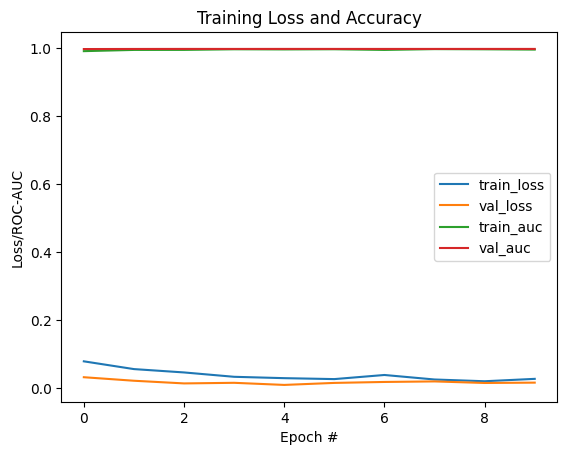

In [34]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [35]:
# upload file align_faces and mtcnn.detector here
from google.colab import files
files.upload()

Saving align_faces.py to align_faces.py
Saving align_mtcnn.py to align_mtcnn.py


{'align_faces.py': b'# -*- coding: utf-8 -*-\n"""\nCreated on Mon Apr 24 15:43:29 2017\n@author: zhaoy\n"""\nimport cv2\nimport numpy as np\nfrom skimage import transform as trans\n\n# reference facial points, a list of coordinates (x,y)\nREFERENCE_FACIAL_POINTS = [\n    [30.29459953, 51.69630051],\n    [65.53179932, 51.50139999],\n    [48.02519989, 71.73660278],\n    [33.54930115, 92.3655014],\n    [62.72990036, 92.20410156]\n]\n\nDEFAULT_CROP_SIZE = (96, 112)\n\n\nclass FaceWarpException(Exception):\n    def __str__(self):\n        return \'In File {}:{}\'.format(\n            __file__, super.__str__(self))\n\n\ndef get_reference_facial_points(output_size=None,\n                                inner_padding_factor=0.0,\n                                outer_padding=(0, 0),\n                                default_square=False):\n    tmp_5pts = np.array(REFERENCE_FACIAL_POINTS)\n    tmp_crop_size = np.array(DEFAULT_CROP_SIZE)\n\n    # 0) make the inner region a square\n    if default_

In [36]:
!pip install mtcnn # Make sure that mtcnn is installed
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn import MTCNN # The correct class name is MTCNN
from tensorflow.keras.models import load_model

/content/align_faces.py:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if align_type is 'cv2_affine':
/content/align_faces.py:184: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif align_type is 'affine':


- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được ảnh trong gương mặt

**Có thể học viên sẽ thắc mắc tại sao chúng ta phải sử dụng Face Alignemnt?**

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn. Học viên có thể so sánh với **mô hình chỉ có Face Detection mà không có Face Alignment** với mô hình ở phía dưới để so sánh kết quả xem liệu sự có mặt của Face Alignment liệu thật sự có cải thiện kết quả hay không.

In [37]:
from mtcnn import MTCNN
import cv2
import numpy as np

# Initialize the MTCNN detector
detector = MTCNN()

def face_detection(img, output_size=(224, 224), align=False):
    """Detect and optionally align faces in the image.

    Args:
    img (numpy.ndarray): The image in which to detect faces.
    output_size (tuple): The desired size of the output face image.
    align (bool): Whether to align the face based on landmarks.

    Returns:
    numpy.ndarray or None: The aligned or cropped face, or None if no face is detected.
    """
    # Detect faces in the image
    results = detector.detect_faces(img)
    if results:
        # Take the first detected face
        first_result = results[0]
        x, y, width, height = first_result['box']
        keypoints = first_result['keypoints']

        if align and keypoints:
            # Get reference 5 points for the standard face
            reference_5pts = np.array([
                [30.2946 + 8.0000, 51.6963],
                [65.5318 + 8.0000, 51.5014],
                [48.0252 + 8.0000, 71.7366],
                [33.5493 + 8.0000, 92.3655],
                [62.7299 + 8.0000, 92.2041]], dtype=np.float32)
            reference_5pts *= output_size[0] / 112  # Scale reference points to desired output size

            # Extract the actual facial keypoints from the detection result
            actual_5pts = np.array([
                [keypoints['left_eye'][0], keypoints['left_eye'][1]],
                [keypoints['right_eye'][0], keypoints['right_eye'][1]],
                [keypoints['nose'][0], keypoints['nose'][1]],
                [keypoints['mouth_left'][0], keypoints['mouth_left'][1]],
                [keypoints['mouth_right'][0], keypoints['mouth_right'][1]]
            ], dtype=np.float32)

            # Compute the transformation matrix
            trans_matrix = cv2.getAffineTransform(actual_5pts[0:3], reference_5pts[0:3])
            img = cv2.warpAffine(img, trans_matrix, (output_size[0], output_size[1]))

            # Optionally cut out the aligned face region
            face = img[:output_size[1], :output_size[0]]
        else:
            # No alignment, just resize the face region
            face = img[y:y+height, x:x+width]
            face = cv2.resize(face, output_size)

        return face

    return None


- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [38]:
test_X_align = test_X.copy()
test_X_align.shape

(2400, 224, 224, 3)

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [40]:
test_X_align = test_X.copy()

choose = []

for i in range(len(test_X)):
    try:
        # Perform face detection combined with Face Alignment, return image size 224x224
        aligned_face = face_detection(test_X[i].astype('uint8'), (224, 224), align=True)
        if aligned_face is not None:
            test_X_align[i] = aligned_face
            # Save the index of the successfully detected face
            choose.append(i)
    except Exception as e:
        # If the image cannot be processed, skip it
        print(f"Error processing image index {i}: {str(e)}")
        continue

choose = np.array(choose)

print(f"Processed {len(choose)} images successfully.")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 21ms/step
Processed 1899 images successfully.


- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [41]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [48]:
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:
predict = model.predict(test_X_align[choose])
roc_auc = roc_auc_score(test_Y[choose], predict)
print(f"ROC-AUC: {roc_auc}")

60/60 [==============================] - 2s 35ms/step
ROC-AUC: 0.9967480871100647


## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [54]:
def mask_detect(image, model):
    img = image.copy()
    detector = MTCNN()

    # Attempt to detect faces
    results = detector.detect_faces(img)
    if not results:
        print("No faces detected.")
        return img

    for result in results:
        bounding_box = result['box']
        keypoints = result['keypoints']

        # Ensure the bounding boxes fall within the dimensions of the frame
        startX, startY, width, height = bounding_box
        startX, startY = max(0, startX), max(0, startY)
        endX, endY = min(img.shape[1] - 1, startX + width), min(img.shape[0] - 1, startY + height)

        # Extract the face ROI, resize it to 224x224
        face = img[startY:endY, startX:endX]
        face = cv2.resize(face, (224, 224))

        # Predict mask presence
        face = np.expand_dims(face, axis=0)  # Model expects batch dimension
        (mask, withoutMask) = model.predict(face)[0]

        # Determine the class label and color for drawing
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # Display the label and bounding boxes
        cv2.putText(img, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)

    return img


- Nhận diện một vài bức ảnh có sẵn trong thư mục image

1/1 [==============================] - 1s 1s/step


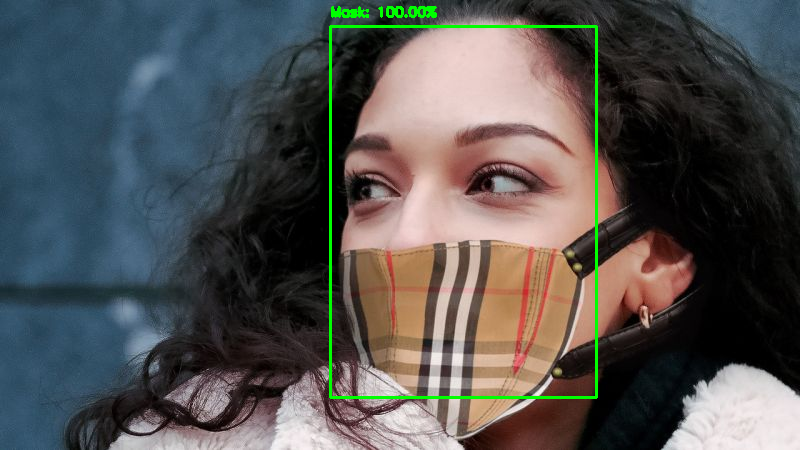

In [58]:
from google.colab.patches import cv2_imshow
img_path = "dataset/data/with_mask/with_mask_3477.jpg"
img = cv2.imread(img_path)
model = load_model('/content/efficientnet.model')  # Load pre-trained model
processed_img = mask_detect(img, model)

# Display the processed image
cv2_imshow(processed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 1s 1s/step


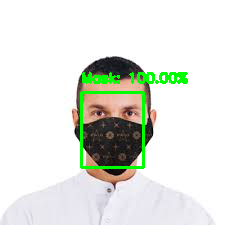

In [59]:
from google.colab.patches import cv2_imshow
img_path = "dataset/data/with_mask/with_mask_3074.jpg"
img = cv2.imread(img_path)
model = load_model('/content/efficientnet.model')  # Load pre-trained model
processed_img = mask_detect(img, model)

# Display the processed image
cv2_imshow(processed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 108ms/step
No faces detected.


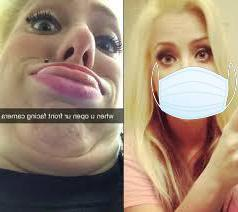

In [60]:
from google.colab.patches import cv2_imshow
img_path = "dataset/data/with_mask/with_mask_2026.jpg"
img = cv2.imread(img_path)
model = load_model('/content/efficientnet.model')  # Load pre-trained model
processed_img = mask_detect(img, model)

# Display the processed image
cv2_imshow(processed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 107ms/step
No faces detected.


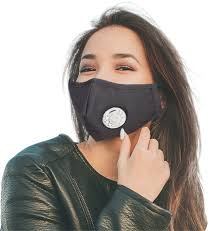

In [62]:
from google.colab.patches import cv2_imshow
img_path = "dataset/data/with_mask/with_mask_2180.jpg"
img = cv2.imread(img_path)
model = load_model('/content/efficientnet.model')  # Load pre-trained model
processed_img = mask_detect(img, model)

# Display the processed image
cv2_imshow(processed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [64]:
from imutils.video import VideoStream
import imutils

In [68]:
import cv2
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

def mask_detection_video():
    # Load the trained model for mask detection
    model = load_model('/content/efficientnet.model')

    # Initialize the MTCNN detector for face detection
    detector = MTCNN()

    # Start video capture from the default camera
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Detect faces in the frame
        faces = detector.detect_faces(frame)

        for face in faces:
            x, y, width, height = face['box']
            x, y = max(0, x), max(0, y)
            face_img = frame[y:y+height, x:x+width]
            face_img = cv2.resize(face_img, (224, 224))
            face_img = face_img.reshape((1, 224, 224, 3))

            # Predict mask or no mask
            (mask, withoutMask) = model.predict(face_img)[0]
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            # Display the label and bounding box
            cv2.putText(frame, f"{label}: {max(mask, withoutMask) * 100:.2f}%", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.rectangle(frame, (x, y), (x + width, y + height), color, 2)

        # Display the resulting frame
        cv2.imshow('Video', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
mask_detection_video()

Failed to grab frame


# 6. Cải thiện mô hình

- Phần này học viên sẽ tự đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình tốt hơn có thể có. Tức là chỉ số **ROC-AUC >= 0.992**. Một số phương pháp được đề xuất như sau:

1. Cải thiện model nhận diện đeo khẩu trang.

2. Cải thiện model phát hiện khuôn mặt.

3. Sử dụng thêm dữ liệu cho quá trình huấn luyện.

4. Cải thiện phần face alignment

In [ ]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:
# Về cơ bản, điểm ROC_AUC đã ra ROC-AUC: 0.9967480871100647 nên em sẽ bỏ qua phần này.